In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from nltk import bigrams, trigrams, ngrams, word_tokenize
from nltk.corpus import stopwords

from string import punctuation

from collections import defaultdict

from itertools import chain # Con esto vamos a juntas todos los ngramas en un corpus...

In [248]:
df = pd.read_csv("train_train.csv")
df_test = pd.read_csv("train_test.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533 entries, 0 to 3532
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  3533 non-null   int64 
 1   Unnamed: 0    3533 non-null   int64 
 2   Title         3532 non-null   object
 3   Opinion       3531 non-null   object
 4   Place         3533 non-null   object
 5   Gender        3533 non-null   object
 6   Age           3533 non-null   int64 
 7   Country       3533 non-null   object
 8   Date          3533 non-null   object
 9   Label         3533 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 276.1+ KB


In [249]:
"""
# Dividir el conjunto de datos...
X = df.drop(["Label"], axis = 1)
y = df["Label"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combinar X_train y y_train en un DataFrame nuevamente...
df = X_train.copy()
df["Label"] = y_train.values
df.to_csv("train_train.csv")

# Combinar X_train y y_train en un DataFrame nuevamente...
df_test = X_test.copy()
df_test["Label"] = y_test.values
df_test.to_csv("train_test.csv")
""";

In [250]:
# Preprocesamiento completo...

# Creando un set con los signos de puntuación...
punctuations = set(punctuation)

# Obtener las stopwords en español...
stop_words_spanish = set(stopwords.words('spanish'))

# De la lista de Stop words vamos a eliminar unas cuantas que quizás si aporten algo al contexto...
preservar = set(['algo', 'algunas', 'algunos', 'contra', 'fue', 'fueron', 'mucho', 'muchos', 'muy', 'más', 'nada', 'ni', 'no', 'pero', 'poco', 'sí', 'también', 'tanto', 'todo', 'todos'])

sw_final = stop_words_spanish - preservar
sw_final = sorted(sw_final)

# Vamos a unir las columnas de texto en cuestión para la primera prueba...
# Crear una función para concatenar las columnas "Title" y "Opinion"...
def concatenate_columns(row):
    # Convertir ambos valores a cadenas, si son None o NaN, los convertirá en una cadena vacía...
    title = str(row["Title"]) if pd.notna(row["Title"]) else ""
    opinion = str(row["Opinion"]) if pd.notna(row["Opinion"]) else ""

    if (title != "") and (opinion != ""):
        return title + ". " + opinion
    elif (title == ""):
        return opinion
    elif (opinion == ""):
        return title
    
# Definir una función para agregar <SOS> delante de cada palabra que inicie una oración
def add_sos(text):
    # Expresión regular para encontrar el inicio de una oración
    modified_text = re.sub(r'(?<!\w)([A-Z][a-z]*\b)', r'startofsentence \1', text)
    return modified_text

# Hasta aquí muy fácil... ahora vamos a ver que palabras son menos frecuentes y sustituirlas por <UNK>
# Pero primero hay que Tokenizar...

# Crear una función para tokenizar y eliminar signos de puntuación
def tokenize_and_remove_punctuation(text):
    # Convertir a minúsculas y tokenizar el texto
    tokens = word_tokenize(text.lower())
    
    # Eliminar signos de puntuación...
    tokens = [word for word in tokens if word not in punctuations] 
    
    # Mantener solo palabras alfabéticas...
    tokens = [word for word in tokens if word.isalpha()]

    # Eliminar las stopwords acordadas...
    tokens = [word for word in tokens if word not in sw_final]

    # Eliminar palabras de 1 solo caracter, que se pudieron haber escapado...
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

# Crear una función para tokenizar y eliminar signos de puntuación
def sustituir_unknown(tokens):
    # Partimos de un texto ya tokenizado...
    
    # Sustituir por "unknown" las palabras que están en el set unknown...
    # tokens = [word if word not in unknown else "unknown" for word in tokens] # No funcionaría ante un set de palabras desconocido...

    # Sustituir palabras que no están en el conjunto 'known' por "unknown"
    tokens = [word if word in known else "unknown" for word in tokens]
    
    return tokens

# Crear un defaultdict para contar palabras...
# Contar palabras nos da la medida de cual es el mínimo de ngramas que serán únicos...
# Sin embargo no es palabras lo que queremos contar, sino n-gramas...
# Sustituiremos las palabras que se encontraron solo una vez... al haber quedado el corpus tan pequeño (11 155 palabras después de eliminar stopwords),
# esta cifra es grande... 5718... Por "unknown"...

def word_count_dict(df):
    word_count = defaultdict(int)

    # Recorrer todos las reseñas y contar los ngramas...
    for tokens in df["Tokens"]:
        for token in tokens:
            word_count[token.lower()] += 1

    # Mostrar los conteos de palabras
    # for word, count in word_count.items():
    #    print(f"{word}: {count}")

    # Convertir el diccionario en un DataFrame
    df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])

    df_word_count.sort_values(by='count', ascending=False, inplace=True)

    # Sacamos las palabras de 1 sola aparición... para sustituirlas por "unknown"...
    # df_word_count[df_word_count["count"].apply(lambda x: x == 1)] # Si quisieramos ver el listado...
    known = set(df_word_count.loc[df_word_count["count"].apply(lambda x: x >= 2), "word"])     # >=11 Originalmente...
    unknown = set(df_word_count.loc[df_word_count["count"].apply(lambda x: x < 2), "word"])    # < 11 Originalmente...

    return unknown, known

# Función para generar n-gramas a partir de una lista de tokens
def generate_ngrams(text, n):
    # Tokenizar el texto
    # tokens = word_tokenize(text.lower())
    
    # Generar los n-gramas
    n_grams = list(ngrams(text, n))
    
    return n_grams

def preparar_df(df):
    # Aligerando el DataFrame...
    df = df[["Title", "Opinion", "Label"]].copy()

    df["Texto"] = df.apply(concatenate_columns, axis=1)
    df = df[["Texto", "Label"]].copy()

    # Eliminando las comillas dobles en el texto final, si existen...
    df["Texto"] = df["Texto"].str.replace('"', '')

    # Aplicar la función a la columna de texto
    df["Texto"] = df["Texto"].apply(add_sos)

    # Aplicar la función a la columna de texto modificado
    df["Tokens"] = df["Texto"].apply(tokenize_and_remove_punctuation)

    return df.copy()

df = preparar_df(df)
df_test = preparar_df(df_test)

# Sustituir por UNKNOWN...
unknown, known = word_count_dict(df)

def crear_ngramas(df):
    # Aplicar la función a la columna de texto modificado
    df["Tokens"] = df["Tokens"].apply(sustituir_unknown)

    # Crear las nuevas columnas con los n-gramas...
    for n in range(2,6):
        df[f'n{n}-grams'] = df['Tokens'].apply(lambda x: generate_ngrams(x, n))

    return df.copy()

df = crear_ngramas(df)
df_test = crear_ngramas(df_test)

# Démosle ya un vistazo al DataFrame...
df_test.head(5)

,Texto,Label,Tokens,n2-grams,n3-grams,n4-grams,n5-grams
0,¡startofsentence Interesante!. startofsentence...,1,"[interesante, startofsentence, si, vas, starto...","[(interesante, startofsentence), (startofsente...","[(interesante, startofsentence, si), (startofs...","[(interesante, startofsentence, si, vas), (sta...","[(interesante, startofsentence, si, vas, start..."
1,startofsentence Hermoso museo. startofsentence...,1,"[startofsentence, hermoso, museo, startofsente...","[(startofsentence, hermoso), (hermoso, museo),...","[(startofsentence, hermoso, museo), (hermoso, ...","[(startofsentence, hermoso, museo, startofsent...","[(startofsentence, hermoso, museo, startofsent..."
2,startofsentence Enorme. startofsentence Excele...,1,"[startofsentence, enorme, startofsentence, exc...","[(startofsentence, enorme), (enorme, startofse...","[(startofsentence, enorme, startofsentence), (...","[(startofsentence, enorme, startofsentence, ex...","[(startofsentence, enorme, startofsentence, ex..."
3,startofsentence El mejor lugar para los enamor...,1,"[startofsentence, mejor, lugar, enamorados, st...","[(startofsentence, mejor), (mejor, lugar), (lu...","[(startofsentence, mejor, lugar), (mejor, luga...","[(startofsentence, mejor, lugar, enamorados), ...","[(startofsentence, mejor, lugar, enamorados, s..."
4,startofsentence Visita obligatoria. startofsen...,0,"[startofsentence, visita, obligatoria, startof...","[(startofsentence, visita), (visita, obligator...","[(startofsentence, visita, obligatoria), (visi...","[(startofsentence, visita, obligatoria, starto...","[(startofsentence, visita, obligatoria, starto..."


In [251]:
# Entrenar todo el clasificador...
# Definir la columna para entrenar y clasificar...
col_ngramas = "n2-grams"

# Una función para dar un valor numérico único a cada n-grama...
def valor_final(prop):
    if prop < 0.51:
        return -1
    elif prop >= 0.51 and prop < 0.75:
        return 0
    elif prop >= 0.75:
        return 1

def clasificador(df, columna):
    # Ahora si vamos a contar n-gramas... "n2-gramas"...
    # Tomaremos en cuenta solo los n-gramas que aparezcan al menos 11 veces...
    # Este conteo puede confundir... ya que dice cuantas veces aparece el n-grama, pero no en cuantas reseñas diferentes...
    # Pudo darse un caso en que en una sola reseña apareciera varias veces...
    # Esto lo vamos a resolver más adelante...

    n_grams_count = defaultdict(int)

    # Recorrer todos los ngramas y contar las frecuencias...
    for n_grams in df[columna]:
        for n_gram in n_grams:
            n_grams_count[n_gram] += 1

    # Convertir el diccionario en un DataFrame
    df_n_grams_count = pd.DataFrame(list(n_grams_count.items()), columns=['n-gram', 'count'])

    df_n_grams_count.sort_values(by='count', ascending=False, inplace=True)
    df_n_grams_count = df_n_grams_count[df_n_grams_count["count"] >= 2] # > 10 Originalmente...
    # df_n_grams_count

    # Crear un diccionario para almacenar los resultados
    ngram_labels = defaultdict(list)

    # Iterar sobre cada fila en df_word_count
    for _, row in df_n_grams_count.iterrows():
        ngram = row["n-gram"]
        # Buscar el n-grama en la columna "n2-grams" del DataFrame df
        matching_labels = df[df[columna].apply(lambda x: ngram in x)]["Label"]
        
        # Almacenar los labels encontrados para este n-grama
        ngram_labels[ngram] = matching_labels.tolist()

    # Convertir el diccionario en un DataFrame
    df_n_grams_labels = pd.DataFrame(list(ngram_labels.items()), columns=['n-gram', 'Labels'])

    df_n_grams_labels["Total"] = df_n_grams_labels["Labels"].apply(lambda x: len(x))
    df_n_grams_labels["Positivas"] = df_n_grams_labels["Labels"].apply(lambda x: sum(x))
    df_n_grams_labels["Prop_Pos"] = df_n_grams_labels["Labels"].apply(lambda x: round(sum(x) / len(x), 2))
    df_n_grams_labels["Valor"] = df_n_grams_labels["Prop_Pos"].apply(valor_final)
    # df_n_grams_labels

    # Vamos a crear un diccionario donde almacenar los valores asignados a cada ngrama...
    ngrams_value = defaultdict(int)
    ngrams_value.update(zip(df_n_grams_labels['n-gram'], df_n_grams_labels['Valor']))

    return ngrams_value

ngrams_value = clasificador(df, col_ngramas)     # ngrams_value = clasificador(df, "n2-grams")

In [252]:
# Recuperar el valor...
ngrams_value[('unknown', 'unknown')], ngrams_value[('no', 'unknown')], ngrams_value[('pero', 'no')]

(0, 0, -1)

In [253]:
# Pedir un ngrama que no exista... devlverá 0...
ngrams_value[('new_unknown', 'new_unknown')]

0

In [254]:
# Crear una función para asignarle un valor a cada opinion...

# Valor de la etiqueta según suma de los valores de los ngramas...
def etiqueta(suma):
    if suma < 4:    # Anteriormente... < 4... No dio mucho resultado moverle aquí... Pero si aumentó para la clase 0 en 0.01 - 0.02...
        return 0
    else:
        return 1

def clasifica(df, columna):
    column_val = []
    column_suma = []

    # Recorrer todos los ngramas y contar las frecuencias...
    for n_grams in df[columna]:
        lista_val = []
        for n_gram in n_grams:
            valor = ngrams_value[n_gram]
            lista_val.append(valor)
        column_val.append(lista_val)
        column_suma.append(np.sum(lista_val))

    df["Valores"] = column_val
    df["Suma"] = column_suma

    df["Label_pred"] = df["Suma"].apply(etiqueta)

    return df.copy()

df = clasifica(df, col_ngramas)              # df = clasifica(df, "n2-grams")
df_test = clasifica(df_test, col_ngramas)    # df_test = clasifica(df_test, "n2-grams")
df_test

,Texto,Label,Tokens,n2-grams,n3-grams,n4-grams,n5-grams,Valores,Suma,Label_pred
0,¡startofsentence Interesante!. startofsentence...,1,"[interesante, startofsentence, si, vas, starto...","[(interesante, startofsentence), (startofsente...","[(interesante, startofsentence, si), (startofs...","[(interesante, startofsentence, si, vas), (sta...","[(interesante, startofsentence, si, vas, start...","[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...",11,1
1,startofsentence Hermoso museo. startofsentence...,1,"[startofsentence, hermoso, museo, startofsente...","[(startofsentence, hermoso), (hermoso, museo),...","[(startofsentence, hermoso, museo), (hermoso, ...","[(startofsentence, hermoso, museo, startofsent...","[(startofsentence, hermoso, museo, startofsent...","[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",12,1
2,startofsentence Enorme. startofsentence Excele...,1,"[startofsentence, enorme, startofsentence, exc...","[(startofsentence, enorme), (enorme, startofse...","[(startofsentence, enorme, startofsentence), (...","[(startofsentence, enorme, startofsentence, ex...","[(startofsentence, enorme, startofsentence, ex...","[1, -1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]",4,1
3,startofsentence El mejor lugar para los enamor...,1,"[startofsentence, mejor, lugar, enamorados, st...","[(startofsentence, mejor), (mejor, lugar), (lu...","[(startofsentence, mejor, lugar), (mejor, luga...","[(startofsentence, mejor, lugar, enamorados), ...","[(startofsentence, mejor, lugar, enamorados, s...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,1
4,startofsentence Visita obligatoria. startofsen...,0,"[startofsentence, visita, obligatoria, startof...","[(startofsentence, visita), (visita, obligator...","[(startofsentence, visita, obligatoria), (visi...","[(startofsentence, visita, obligatoria, starto...","[(startofsentence, visita, obligatoria, starto...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",8,1
...,...,...,...,...,...,...,...,...,...,...
879,"startofsentence Bueno,aunque caro.. startofsen...",0,"[startofsentence, bueno, aunque, caro, startof...","[(startofsentence, bueno), (bueno, aunque), (a...","[(startofsentence, bueno, aunque), (bueno, aun...","[(startofsentence, bueno, aunque, caro), (buen...","[(startofsentence, bueno, aunque, caro, starto...","[0, 0, 0, -1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",1,0
880,startofsentence Bueno. startofsentence El muse...,1,"[startofsentence, bueno, startofsentence, muse...","[(startofsentence, bueno), (bueno, startofsent...","[(startofsentence, bueno, startofsentence), (b...","[(startofsentence, bueno, startofsentence, mus...","[(startofsentence, bueno, startofsentence, mus...","[0, 1, 1, 0, 0, -1, 1, -1, 1, -1, 0, -1, 0, 0,...",10,1
881,Callejón romántico. startofsentence Parte de l...,1,"[callejón, romántico, startofsentence, parte, ...","[(callejón, romántico), (romántico, startofsen...","[(callejón, romántico, startofsentence), (romá...","[(callejón, romántico, startofsentence, parte)...","[(callejón, romántico, startofsentence, parte,...","[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1,...",20,1
882,startofsentence Excelente teatro. startofsente...,1,"[startofsentence, excelente, teatro, startofse...","[(startofsentence, excelente), (excelente, tea...","[(startofsentence, excelente, teatro), (excele...","[(startofsentence, excelente, teatro, startofs...","[(startofsentence, excelente, teatro, startofs...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...",12,1


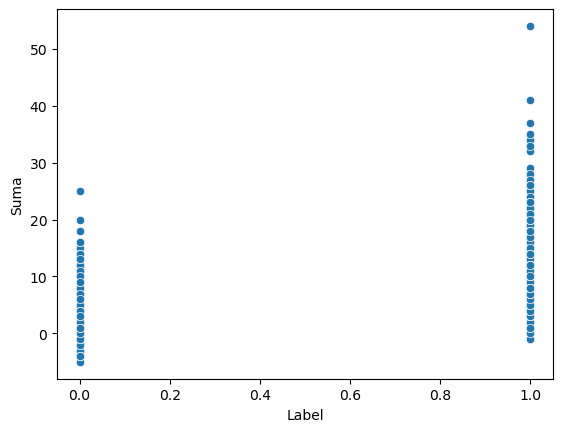

In [255]:
# Visualizando...
sns.scatterplot(data = df_test, x = "Label", y = "Suma")
plt.show()

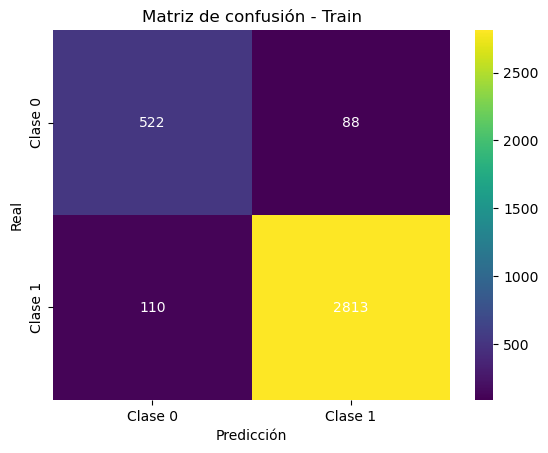

In [256]:
# Calcular la matriz de confusión...
def matriz(df):
    cm = confusion_matrix(df["Label"], df["Label_pred"])    
    return cm

# Mostrando la matriz de confusión...
cm = matriz(df)
# print("Matriz de confusión:")
# print(cm)

# Crear el Heatmap...
sns.heatmap(cm, annot=False, fmt="d", cmap='viridis', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])

# Añadir etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title("Matriz de confusión - Train")

# Añadir los valores dentro de cada celda manualmente
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm[i, j]:d}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()

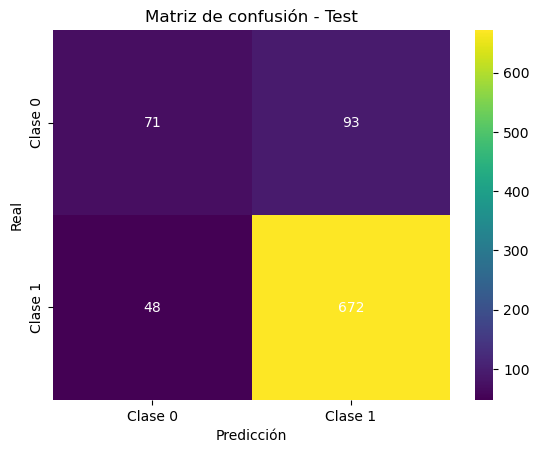

In [257]:
cm_test = matriz(df_test)
# print("Matriz de confusión:")
# print(cm_test)

# Crear el Heatmap...
sns.heatmap(cm_test, annot=False, fmt="d", cmap='viridis', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])

# Añadir etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title("Matriz de confusión - Test")

# Añadir los valores dentro de cada celda manualmente
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_test[i, j]:d}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()

In [258]:
# Calculando métricas...
def metricas(df):
    y_true, y_pred = df["Label"], df["Label_pred"]

    # Calcular métricas globales...
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    f1_balanced = f1_score(y_true, y_pred, average='macro')  # F1 Score balanceado
    f1_weighted = f1_score(y_true, y_pred, average='weighted')  # F1 Score ponderado

    # Calcular métricas para cada clase...
    class_report = classification_report(y_true, y_pred, output_dict=True)

    # Mostrar resultados de las métricas ...
    print(f'Precisión: {accuracy:.2f}')
    print(f'Precisión (para clase positiva): {precision:.2f}')
    print(f'Exhaustividad: {recall:.2f}')
    print(f'Puntuación F1: {f1:.2f}')
    print(f'F1 Score Balanceado: {f1_balanced:.2f}')  # Imprimir F1 Score balanceado
    print(f'F1 Score Ponderado: {f1_weighted:.2f}')  # Imprimir F1 Score ponderado

    # Mostrar F1 ponderado por clase...
    for class_label, metrics in class_report.items():
        if class_label.isdigit():  # Evita mostrar los promedios 'macro avg' y 'weighted avg'
            print(f'F1 Score ponderado para clase {class_label}: {metrics["f1-score"]:.2f}')

print("Métricas para el Test...")
metricas(df_test)

Métricas para el Test...
Precisión: 0.84
Precisión (para clase positiva): 0.88
Exhaustividad: 0.93
Puntuación F1: 0.91
F1 Score Balanceado: 0.70
F1 Score Ponderado: 0.83
F1 Score ponderado para clase 0: 0.50
F1 Score ponderado para clase 1: 0.91
